In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import scipy.stats as stats
import statsmodels.api as sm
from tqdm import tqdm

In [2]:
# Sarah DATADIR TODO
DATADIR = "data/"

# Normal Model

In [65]:
def load_nfl_data(season=2017):
    """Loads in NFL match result data from CSV file located in your DATADIR
    
    :param season: The season we want to do analysis on
    :return: a pandas dataframe containing the scores of every NFL game in the
        given season
    """
    NFL = pd.read_csv(DATADIR+'NFL_Scores.csv')

    # select the relevant season
    NFL_season = NFL[NFL.schedule_season==season]
    # remove play-off games
    NFL_season = NFL_season.iloc[:-11]
    return NFL_season

def get_X(teams,NFL_season):
    """Creates the X matrix for the normal model calculation

    :param teams: numpy array of all unique teams in the match result dataset
    :param NFL_season: pandas dataframe containing NFL match result data
    :return: A numpy array where each row is a unique game of the dataset, and each column represents a team
    """
    # calculate number of teams
    nteams = teams.size
    # calculate number of games
    ngames = NFL_season.shape[0]
    # assign each game a unique id
    game_id = np.arange(ngames)
    # initalize X matrix
    X = np.zeros((ngames,nteams))
    # populate home teams
    home_team_idx = np.searchsorted(teams,NFL_season.team_home)
    X[game_id,home_team_idx] = 1
    # populate away teams
    away_team_idx = np.searchsorted(teams,NFL_season.team_away)
    X[game_id,away_team_idx] = -1    
    return X

def get_W(nteams):
    """Creates the W matrix for the normal model calculation, with the constraint that team strengths must sum to 0

    :param nteams: An integer representing the number of teams in our dataset for generating the W matrix
    :return: W matrix for estimating team strength
    """
    # set up an nteams x nteams identify matrix
    W = np.eye(nteams)
    # set all elements in the last row = -1
    W[-1,:] = -1
    # remove the last column
    W = W[:,:-1]
    return W

def make_team_strength_plot(season,team_params):
    teamnames = [t[0] for t in team_params]
    theta_ = [t[1] for t in team_params]
    # plot outcomes
    fig, ax = plt.subplots(figsize=(6,8))
    ax.barh(teamnames,theta_,facecolor='red',alpha=0.3,height=0.5)
    fig.suptitle('         Team strength estimates, NFL %d-%d' % (season,season+1),y=0.92)
    ax.set_xlabel('Team strength')
    ax.xaxis.grid(True)
    fig.subplots_adjust(left=0.3)


3.265625 15.1737254278366
New Orleans Saints,11.396,3.323
Green Bay Packers,11.356,3.323
New England Patriots,9.271,3.323
San Francisco 49ers,8.312,3.323
Baltimore Ravens,6.097,3.323
Detroit Lions,6.067,3.323
Pittsburgh Steelers,5.286,3.323
Philadelphia Eagles,4.723,3.323
Houston Texans,4.540,3.323
Atlanta Falcons,3.529,3.323
Chicago Bears,1.655,3.323
Dallas Cowboys,1.627,3.323
New York Giants,1.588,3.323
Miami Dolphins,0.946,3.323
New York Jets,0.907,3.323
San Diego Chargers,0.870,3.323
Seattle Seahawks,0.797,3.323
Cincinnati Bengals,0.461,3.323
Tennessee Titans,-0.998,3.323
Carolina Panthers,-1.297,3.323
Arizona Cardinals,-2.215,3.323
Buffalo Bills,-3.370,3.323
Washington Redskins,-4.122,3.323
Oakland Raiders,-4.925,3.323
Denver Broncos,-5.296,3.323
Cleveland Browns,-5.389,3.323
Jacksonville Jaguars,-5.640,3.323
Minnesota Vikings,-5.726,3.323
Kansas City Chiefs,-8.100,3.323
St. Louis Rams,-10.449,3.323
Tampa Bay Buccaneers,-10.615,3.323
Indianapolis Colts,-11.285,3.323
Beta,3.266, 0.

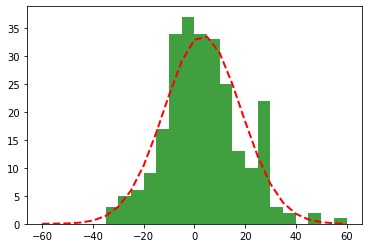

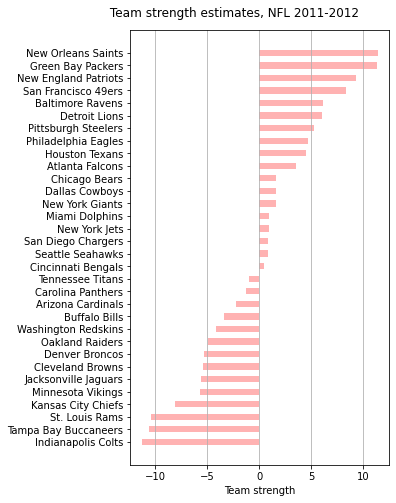

In [66]:
# START SCRIPT

season = 2011
# season = 2014
NFL_season = load_nfl_data(season=season)

score_diff = NFL_season.score_home-NFL_season.score_away
(mu, sigma) = stats.norm.fit(score_diff)

# the histogram of the data
fig,ax = plt.subplots()
n, bins, patches = ax.hist(score_diff, np.arange(-60,65,5),facecolor='green', alpha=0.75)

# add a 'best fit' line
y = stats.norm.pdf( bins, mu, sigma)
print(mu,sigma)
ax.plot(bins, y*score_diff.size*5, 'r--', linewidth=2)

# find all the team names (and sort)
teams = np.unique( NFL_season[['team_home','team_away']] )
# calculate number of teams
nteams = teams.size
# calculate number of games
ngames = NFL_season.shape[0]
# calculate design matrix
X = get_X(teams,NFL_season)
# get observed score differentials
y = NFL_season.score_home - NFL_season.score_away
# construct linear constraint matrix
W = get_W(nteams)
# Add extra row and column for home advantage
Wh = block_diag(W,[1])

Xh = np.c_[X,np.ones(ngames)]
Xhs = np.matmul(Xh,Wh)

# solution! (the @ symbol is another way of doing matrix multiplication in python)
gamma = np.linalg.inv( Xhs.T @ Xhs ) @ Xhs.T @ y 
# the n-1 strength parameters 

theta_n1 = gamma[:-1]
#  home advantage parameter
beta = gamma[-1]
# calculate the nth team strength
theta_n = np.append( theta_n1,-theta_n1.sum() )
yhat = Xh @ np.append( theta_n,beta )

# variance of residuals
svar = np.dot(y-yhat,y-yhat) / (ngames-nteams)
# covariance matrix of coefficients
theta_covar = svar * Wh @ np.linalg.inv( Xhs.T @ Xhs ) @ Wh.T 
# standard errors of  coefficients
theta_sigma = np.sqrt( np.diagonal(theta_covar) )

# now list & plot soltuions

team_params = []
for team,theta,sigma in zip(teams,theta_n,theta_sigma):
    team_params.append((team,theta.round(3),sigma.round(3)))

team_params = sorted(team_params,key=lambda x: x[1], reverse=False)
for tp in team_params[::-1]:
    print("%s,%1.3f,%1.3f" % tuple(tp))
print("Beta,%1.3f, %1.3f" % (beta,theta_sigma[-1]))
print("Residual standard deviation,%1.3f," % (np.sqrt(svar)))

# MAKE_PLOT
make_team_strength_plot(season,team_params)

In [67]:
# define constants 
teamsToDivisions = {"Seattle Seahawks": "NFC West", 
                    "Los Angeles Rams": "NFC West", 
                    "St. Louis Rams": "NFC West", 
                    "Arizona Cardinals": "NFC West", 
                    "San Francisco 49ers": "NFC West", 
                    "New Orleans Saints": "NFC South", 
                    "Tampa Bay Buccaneers": "NFC South", 
                    "Carolina Panthers": "NFC South", 
                    "Atlanta Falcons": "NFC South", 
                    "Washington Redskins": "NFC East",
                    "New York Giants": "NFC East", 
                    "Dallas Cowboys": "NFC East", 
                    "Philadelphia Eagles": "NFC East", 
                    "Green Bay Packers": "NFC North", 
                    "Chicago Bears": "NFC North", 
                    "Minnesota Vikings": "NFC North", 
                    "Detroit Lions": "NFC North", 
                    "Tennessee Titans": "AFC South", 
                    "Indianapolis Colts": "AFC South", 
                    "Houston Texans": "AFC South", 
                    "Jacksonville Jaguars": "AFC South", 
                    "Buffalo Bills": "AFC East", 
                    "Miami Dolphins": "AFC East", 
                    "New England Patriots": "AFC East", 
                    "New York Jets": "AFC East", 
                    "Pittsburgh Steelers": "AFC North",
                    "Baltimore Ravens": "AFC North", 
                    "Cleveland Browns": "AFC North", 
                    "Cincinnati Bengals": "AFC North", 
                    "Kansas City Chiefs": "AFC West", 
                    "Oakland Raiders": "AFC West", 
                    "San Diego Chargers": "AFC West", 
                    "Denver Broncos": "AFC West"
            }
Divisions = np.unique( list(teamsToDivisions.values()) )


In [68]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 26 16:00:35 2020

@author: laurieshaw
"""

def run_sims(team_param_dict,nsims=10000,draw_strengths=True, season = 2015):    
#     we'll simulated the 2015/16 season using team strengths measured from the 2014/15 season
#     season = 2015 # i.e. 2015/16 season 

    # load data
    NFLseason = load_nfl_data(season)

    # get fixture schedule    
    fixtures = NFLseason[['team_home','team_away']]
    fixtures = fixtures.reset_index(drop=True)
    teams = np.unique( fixtures[['team_home','team_away']] )
    
    # store the NFL tables for each simulation in a list    
    tables = []
    # now run the simulations
    for i in tqdm(np.arange(nsims)):
        if draw_strengths:
            # treat the team strength of each team as a random varaible, drawing from a distribution determined by their expected value and sample error
            sim_param_dict = draw_from_strength_params(teams,team_param_dict)
        else:
            # don't draw team strenghts, just keep them fixed at their expected value
            sim_param_dict = team_param_dict
        # simulate the season once
        completed_fixtures = sim_season(fixtures,sim_param_dict)
        # append the league table for simulated season to the list
        tables.append( generate_table(completed_fixtures) )
        
    # Analyze the results
    team_summary = analyse_sim_results(tables, teams)
    return tables, team_summary


def draw_from_strength_params(teams,team_param_dict):
    '''
    Draw a new set of team strength, home advantage and intercept parameters from the standard errors on the theta values
    '''
    sim_param_dict = team_param_dict.copy()
    sigma_team = team_param_dict["sigma"]
    for team in teams:
        sim_param_dict[team] = stats.norm.rvs(0,sigma_team,1) + team_param_dict[team]
    
#     sim_param_dict['intercept'] = stats.norm.rvs(0,sigma_beta,1)[0] + team_param_dict['intercept']
    sigma_beta = team_param_dict['beta'][1]
    sim_param_dict['beta'] = stats.norm.rvs(0,sigma_beta,1) + team_param_dict['beta'][0]
    return sim_param_dict

def sim_match(home,away,team_param_dict):    
    # calculate the mean score differential (using team strengths & home advantage)
    mu_diff = team_param_dict[home] - team_param_dict[away] + team_param_dict['beta'][0]
    home_idx = np.where(teams == home)[0][0]
    away_idx = np.where(teams == away)[0][0]
    # calculate and draw a score differential normal random variable
    cov_between = theta_covar[home_idx, away_idx]
    score_diff_var = team_param_dict["sigma"]**2 + team_param_dict["sigma"]**2 - 2 * cov_between

    score_diff = stats.norm.rvs(mu_diff, np.sqrt(score_diff_var), 1)
    return np.round(score_diff,3), np.round(-score_diff, 3)

def sim_season(fixtures,team_param_dict):
    '''
    simulate a single season using the fixtures given in the 'fixtures' dataframe
    '''
    # make a copy of the fixture list. we'll populate this with the results
    completed_fixtures = fixtures.copy()
    nmatches = fixtures.shape[0]
    homeScoreDiffs = np.zeros(nmatches)
    awayScoreDiffs = np.zeros(nmatches)
    # go through fixture schedule and simulated each match
    for i,row in completed_fixtures.iterrows():
        homeScoreDiffs[i],awayScoreDiffs[i] = sim_match(row['team_home'],row['team_away'],team_param_dict)
    # fill in scores in fixture schedule
    completed_fixtures['homeScoreDiffs'] = homeScoreDiffs
    completed_fixtures['awayScoreDiffs'] = awayScoreDiffs
    return completed_fixtures
    
def generate_table(results):
    ''' 
    produce a league table from a simulation of a single team
    '''
    teams = np.unique( results[['team_home','team_away']] )
    table = []
    # loop through each team
    for team in teams:
        # get all the team's home & away games
        homegames = results[results['team_home']==team]
        awaygames = results[results['team_away']==team]
        
        # calculate the team's home wins/losses
        homeWins = sum(homegames.homeScoreDiffs > 0)
        homeLosses = sum(homegames.homeScoreDiffs < 0)
        # calculate the team's away wins/losses
        awayWins = sum(awaygames.awayScoreDiffs > 0)
        awayLosses = sum(awaygames.awayScoreDiffs < 0)
        # calculate total wins/losses
        totalWins = homeWins + awayWins
        totalLosses = homeLosses + awayLosses
        
        # append results to the table list
        table.append((team,totalWins,totalLosses,homeWins,homeLosses,awayWins,awayLosses))
    # sort the table by points, then homeWins, then awayWins
    
    table = add_ranks(table)
    
    # Sort by team
    table = sorted(table, key = lambda x: (x[0]), reverse=False)
    return table
    
def analyse_sim_results(tables,teams,printout=False, asDataframe=True):
    '''
    analyse the simulation results over all simulations
    '''
    team_summary = []
    nsims = len(tables)
    for teamidx, team in enumerate(teams):
        dfTeam = pd.DataFrame(np.array(tables)[:,teamidx,:],  columns = ["team",
                                                                       "totalWins",
                                                                       "totalLosses",
                                                                       "homeWins",
                                                                       "homeLosses",
                                                                       "awayWins",
                                                                       "awayLosses",
                                                                       "leagueRank",
                                                                       "division", 
                                                                       "divisionRank"])
        
        

        # proportion of sims in which team finished first in the league table
        bestteam = np.sum(dfTeam["leagueRank"]==1)/nsims*100
        # proportion of sims in which team finished in the top 4 
        wonDivision = np.sum(dfTeam["divisionRank"]==1)/nsims*100

        # average Total Wins
        totalWins_mean = np.mean(dfTeam["totalWins"])
        # 2.5th percentile of Total Wins
        totalWins_low = np.percentile(dfTeam["totalWins"],2.5, interpolation='nearest')
        # 97.5th percentile of Total Wins
        totalWins_high = np.percentile(dfTeam["totalWins"],97.5, interpolation='nearest')
        
        # average league finish
        league_mean = np.mean(dfTeam["leagueRank"])
        # 2.5th and 97.5th percentiles of league finish
        league_low = np.percentile(dfTeam["leagueRank"],2.5, interpolation='nearest')
        league_high = np.percentile(dfTeam["leagueRank"],97.5, interpolation='nearest')
        
        # average division finish
        division_mean = np.mean(dfTeam["divisionRank"])
        # 2.5th and 97.5th percentiles of points
        division_low = np.percentile(dfTeam["divisionRank"],2.5, interpolation='nearest')
        division_high = np.percentile(dfTeam["divisionRank"],97.5, interpolation='nearest')
        # add to summary table
        team_summary.append( [team, totalWins_mean, totalWins_low, totalWins_high, 
                              bestteam, league_mean, league_low, league_high, 
                              wonDivision, division_mean, division_low, division_high] )
        
    # sort summary table by mean position
    team_summary = sorted( team_summary, key = lambda x: x[1], reverse=True)

    if printout:
        print("\n******* SUMMARY OF SIMULATION RESULTS **********\n")
        print("Team, Total Wins,Total Wins-low,Total Wins-High,Top Position %,Position-Mean,Position-Low,Position-High,Won Division %,Division-mean, Division-Low,Division-High")
        for i,summary in enumerate(team_summary):
            print("%s,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f" % tuple([i+1]+summary[1:]))
            
    if (asDataframe == True ):
        dfReturn = pd.DataFrame(team_summary, columns = ["team", "totalWins_mean", "totalWins_low", "totalWins_high", 
                              "bestteam", "league_mean", "league_low", "league_high", 
                              "wonDivision", "division_mean", "division_low", "division_high"])
        return dfReturn
    else: 
        return team_summary


def add_ranks(table): 
    df = pd.DataFrame(table, columns = ["team",
                             "totalWins",
                             "totalLosses",
                             "homeWins",
                             "homeLosses",
                             "awayWins",
                             "awayLosses"])
    
    # Add League-wide Ranks
    df["leagueRank"] = df["totalWins"].rank(method='min', ascending = False)

    # Add Divisions
    df["division"] = [ teamsToDivisions[k] for k in df["team"] ]
    
    # Initialize division ranks 
    df["divisionRank"] = np.zeros(len(df["division"] ))

    # Get Division ranks
    for division in Divisions: 
        # Subset Dataframe to appropriate division and get division ranks
        divisionDF = df[df["division"] == division]
        divisionRanks = divisionDF['totalWins'].rank(method="min", ascending = False)
        divisionRanks = dict(zip(divisionDF["team"], divisionRanks))

        # Add division ranks to original DF for each team 
        for team in divisionDF["team"]: 
            teamidx = np.where(df["team"] == team)[0][0]
            df.loc[teamidx, "divisionRank"] = divisionRanks[team]

    # Return numpy array
    return df.to_numpy()


In [11]:
# param dictionary. For use in running simulations
team_param_dict = {t:th for t,th in zip(teams,np.round(theta_n,3))}
team_param_dict['beta'] = (np.round(beta, 3), np.round(theta_sigma[-1], 3))
team_param_dict['sigma'] = np.round(theta_sigma[0], 3)
team_param_dict['intercept'] = 0



In [18]:
tables, team_summary = run_sims(team_param_dict,nsims=10000,draw_strengths=True, season = 2012)

100%|██████████| 10000/10000 [20:54<00:00,  7.97it/s]


In [20]:
# Save data
import pickle
with open("data/tables_seth.pickle", 'wb') as f:
    pickle.dump(tables, f)

# Team Summary to CSV
team_summary.to_csv("data/team_summary_seth.csv", index=False)

In [294]:
# Load data
with open("data/tables.pickle", 'rb') as f:
    tables_loaded = pickle.load(f)

team_summary_loaded = pd.read_csv("data/team_summary.csv")

In [59]:
def strength_of_schedule(fixtures,team_param_dict, season = 2012):
    '''
    Get strength of schedule for a single season using the fixtures given in the 'fixtures' dataframe
    '''
    
    NFLseason = load_nfl_data(season)

    # get fixture schedule    
    fixtures = NFLseason[['team_home','team_away']]
    fixtures = fixtures.reset_index(drop=True)
    
    # make a copy of the fixture list. we'll populate this with the results
    df = pd.DataFrame(index = teams)
    
    # Initialize strength of scheule and copy fixtures just in case
    df["Strength of Schedule"] = np.zeros(len(teams))
    # go through fixture schedule and get team strengths
    
    for i,row in fixtures.iterrows():
        home = row['team_home']
        away = row['team_away']
        df.loc[home, "Strength of Schedule"] += team_param_dict[away] + team_param_dict["beta"][0]
        df.loc[away, "Strength of Schedule"] += team_param_dict[home] - team_param_dict["beta"][0]

    return df

In [63]:
team_summary["SOS"] = strength_of_schedule(fixtures, team_param_dict).to_numpy()

In [72]:
team_summary.drop(columns=["division"])

,team,totalWins_mean,totalWins_low,totalWins_high,bestteam,league_mean,league_low,league_high,wonDivision,division_mean,division_low,division_high,SOS
0,New Orleans Saints,14.2758,11,16,35.04,2.8353,1.0,9.0,91.26,1.0927,1.0,2.0,26.678
1,Green Bay Packers,14.1942,10,16,40.94,3.0531,1.0,11.0,84.13,1.1791,1.0,2.0,-10.815
2,New England Patriots,14.0521,10,16,35.20,3.2662,1.0,11.0,91.19,1.1064,1.0,2.0,0.892
3,San Francisco 49ers,12.4001,8,15,7.37,5.9461,1.0,14.0,90.72,1.0984,1.0,2.0,-8.179
4,Pittsburgh Steelers,12.1107,7,16,11.04,6.7375,1.0,19.0,53.56,1.6137,1.0,3.0,-2.563
5,Baltimore Ravens,11.9073,7,16,9.44,7.1001,1.0,19.0,48.15,1.6791,1.0,3.0,6.786
6,Detroit Lions,11.2378,6,15,3.96,8.3548,1.0,20.0,20.37,2.0104,1.0,3.0,-6.341
7,Houston Texans,11.2269,7,15,3.85,8.3650,1.0,19.0,85.80,1.1553,1.0,2.0,-4.602
8,Philadelphia Eagles,11.0727,5,15,3.84,8.7319,1.0,22.0,70.35,1.4121,1.0,3.0,16.298
9,Atlanta Falcons,10.6510,6,15,1.63,9.5839,2.0,21.0,13.71,2.0172,1.0,3.0,-1.031


In [61]:
# Add divisions 
team_summary["division"] = [ teamsToDivisions[k] for k in team_summary["team"] ]

# Get Division ranks
division_summary = []
for division in Divisions: 
    # Subset Dataframe to appropriate division and get division ranks
    divisionDF = team_summary[team_summary["division"] == division]
    
    divisiontotalWins_mean = np.mean(divisionDF["totalWins_mean"])
    
    division_leaguemean = np.mean(divisionDF["league_mean"])
    
    division_summary.append( [division, divisiontotalWins_mean, division_leaguemean] )

    
# sort summary table by mean position
division_summary = sorted( division_summary, key = lambda x: x[1], reverse=True)
division_summary = pd.DataFrame(division_summary, columns=["division", "totalWins_mean", "league_mean"])
division_summary

,division,totalWins_mean,league_mean
0,NFC North,9.627600,12.204075
1,AFC East,9.421125,12.563800
2,AFC North,9.324850,12.691200
3,NFC South,8.634925,14.331325
4,NFC East,7.844075,15.784050
5,NFC West,6.862275,17.916675
6,AFC West,6.154950,19.597350
7,AFC South,6.128050,19.513600


# Logit Model

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 25 08:54:32 2020

@author: laurieshaw
"""

def load_nfl_data(season=2017):
    NFL = pd.read_csv(DATADIR+'NFL_Scores.csv')

    # select the 2017/18 season
    NFL_season = NFL[NFL.schedule_season==season]
    # remove play-off games
    NFL_season = NFL_season.iloc[:-11]
    return NFL_season

def get_X(teams,NFL_season):
    # calculate number of teams
    nteams = teams.size
    # calculate number of games
    ngames = NFL_season.shape[0]
    # assign each game a unique id
    game_id = np.arange(ngames)
    # initalize X matrix
    X = np.zeros((ngames,nteams))
    # populate home teams
    home_team_idx = np.searchsorted(teams,NFL_season.team_home)
    X[game_id,home_team_idx] = 1
    # populate away teams
    away_team_idx = np.searchsorted(teams,NFL_season.team_away)
    X[game_id,away_team_idx] = -1    
    return X

def get_W(nteams):
    # set up an nteams x nteams identify matrix
    W = np.eye(nteams)
    # set all elements in the last row = -1
    W[-1,:] = -1
    # remove the last column
    W = W[:,:-1]
    return W

def make_team_strength_plot(season,team_params):
    teamnames = [t[0] for t in team_params]
    theta_ = [t[1] for t in team_params]
    # plot outcomes
    fig, ax = plt.subplots(figsize=(6,8))
    ax.barh(teamnames,theta_,facecolor='red',alpha=0.3,height=0.5)
    fig.suptitle('Logistic model team strength estimates, NFL %d-%d' % (season,season+1),y=0.92)
    ax.set_xlabel('Team strength')
    ax.xaxis.grid(True)
    fig.subplots_adjust(left=0.3)


In [64]:
season = 2018 # model fails to converge for 2017 season: can you figure out why?
NFL_season = load_nfl_data(season=season)

# find all the team names
teams = np.unique( NFL_season[['team_home','team_away']] )
# calculate number of teams
nteams = teams.size
# calculate number of games
ngames = NFL_season.shape[0]
# calculate design matrix
X = get_X(teams,NFL_season)
# get observed score differentials
y = NFL_season.score_home - NFL_season.score_away
# construct linear constraint matrix
W = get_W(nteams)
# extend W to account for home advantage parameter
Wh = block_diag(W,[1])

Xh = np.c_[X,np.ones(ngames)]
Xhs = np.matmul(Xh,Wh)


outcome = np.zeros_like(y)
outcome[y>0] = 1.0
outcome[y==0] = 0.5

In [65]:

logit_mod = sm.Logit(outcome, Xhs)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.533614
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  256
Model:                          Logit   Df Residuals:                      224
Method:                           MLE   Df Model:                           31
Date:                Sat, 27 Feb 2021   Pseudo R-squ.:                  0.2082
Time:                        12:16:54   Log-Likelihood:                -136.61
converged:                       True   LL-Null:                       -172.53
Covariance Type:            nonrobust   LLR p-value:                 4.352e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.8496      0.718     -2.575      0.010      -3.258      -0.442
x2            -0.3603      0.

Los Angeles Rams,1.712,0.711
New Orleans Saints,1.640,0.674
Kansas City Chiefs,1.534,0.679
Los Angeles Chargers,1.468,0.674
Chicago Bears,0.802,0.624
New England Patriots,0.793,0.592
Baltimore Ravens,0.773,0.601
Houston Texans,0.768,0.593
Pittsburgh Steelers,0.720,0.574
Dallas Cowboys,0.570,0.579
Seattle Seahawks,0.556,0.597
Indianapolis Colts,0.439,0.579
Tennessee Titans,0.379,0.565
Philadelphia Eagles,0.353,0.574
Minnesota Vikings,0.198,0.612
Cleveland Browns,-0.092,0.578
Carolina Panthers,-0.224,0.561
Atlanta Falcons,-0.360,0.579
Cincinnati Bengals,-0.366,0.598
Washington Redskins,-0.420,0.566
Denver Broncos,-0.448,0.586
Miami Dolphins,-0.515,0.574
Buffalo Bills,-0.588,0.592
Jacksonville Jaguars,-0.695,0.594
Detroit Lions,-0.740,0.579
New York Giants,-0.823,0.594
Tampa Bay Buccaneers,-0.839,0.607
Green Bay Packers,-0.885,0.608
Oakland Raiders,-1.021,0.629
New York Jets,-1.308,0.623
San Francisco 49ers,-1.532,0.670
Arizona Cardinals,-1.850,0.718
Beta,0.548, 0.153


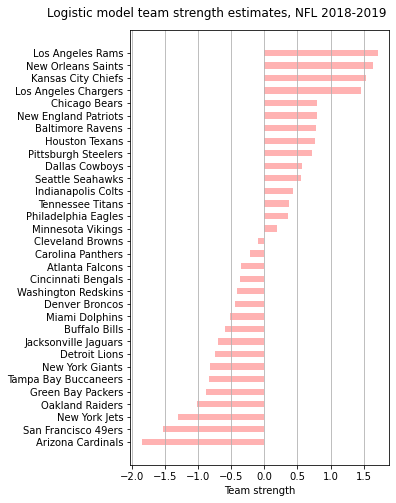

In [66]:
gamma = logit_res.params
theta_n1 = gamma[:-1]
#  home advantage parameter
beta = gamma[-1]
# calculate the nth team strength
theta_n = np.append( theta_n1,-theta_n1.sum() )

# these lines show how to calculate covariance of theta estimates (see, for example, https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients)
yp = logit_res.predict(Xhs)
V = np.diag(yp*(1-yp))
theta_cov = Wh @ np.linalg.inv( Xhs.T @ V @ Xhs ) @ Wh.T  # square root of diagonal element should match std err in printout
theta_sigma = np.sqrt( theta_cov.diagonal() )

# now list & plot soltuions
team_params = []
for team,theta,sigma in zip(teams,theta_n,theta_sigma):
    team_params.append((team,theta.round(3),sigma.round(3)))

team_params = sorted(team_params,key=lambda x: x[1], reverse=False)
for tp in team_params[::-1]:
    print("%s,%1.3f,%1.3f" % tuple(tp))
print("Beta,%1.3f, %1.3f" % (beta,theta_sigma[-1]))


# MAKE_PLOT
make_team_strength_plot(season,team_params)
